In [1]:
#test the model class on JSWT simulations 
import numpy as np
import pandas as pd
#import splat
#import popsims
from astropy.coordinates import SkyCoord, Galactic
#from popsims.galaxy import Pointing, volume_calc, create_pop
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
#sns.set_style("darkgrid", {"axes.facecolor": ".95"})

#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')

from  matplotlib.colors import Normalize
import astropy.units as u
import popsims
import matplotlib
from tqdm import tqdm
from tqdm import tqdm
import matplotlib as mpl 


from popsims.simulator import Population
from popsims.galaxy import Disk, Halo
from popsims.relations import polynomial_relation
import splat.empirical as spe
import warnings
warnings.filterwarnings("ignore")



Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
#SDSS 
SDSS={'FOV': 2.5*u.degree*2.5*u.degree,\
      'l':((np.array([0, 360]))*u.degree.to(u.radian)),\
            'b': ((np.array([-90, 90]))*u.degree.to(u.radian))}

SDSS_discrete={'FOV': 2.5*u.degree*2.5*u.degree,\
      'l':((np.array([0, 360]))*u.degree.to(u.radian)),\
            'b': ((np.array([-90, 90]))*u.degree.to(u.radian))}

In [3]:
DATA_FOLDER='/volumes/Lacie/popsimsdata//'

In [4]:
import astropy.table as astrotable
from astropy.io.votable import parse_single_table

In [5]:
import glob

In [6]:
#forget about sdss use
ffolder='/users/caganze/research/lodieu/*.xml'
lodieu_dfs=[]
for f in glob.glob(ffolder):
    tbl = parse_single_table(f).to_table()
    print('Number of candidates',len(tbl))
    lodieu_dfs.append(tbl.to_pandas())
dfl_conct=pd.concat(lodieu_dfs)

Number of candidates 130
Number of candidates 4
Number of candidates 114
Number of candidates 59
Number of candidates 52
Number of candidates 174
Number of candidates 17
Number of candidates 115
Number of candidates 13
Number of candidates 445
Number of candidates 2
Number of candidates 253


In [7]:
#combine 
ras0=np.nanmedian([dfl_conct['RAJ2000_VHS'].values, dfl_conct['RAJ2000_LAS'].values], axis=0)
decs0=np.nanmedian([dfl_conct['DEJ2000_VHS'].values, dfl_conct['DEJ2000_LAS'].values], axis=0)

In [8]:
assert len(popsims.dropnans(ras0)) == len(dfl_conct)
assert len(popsims.dropnans(decs0)) == len(dfl_conct)

In [9]:
#choose 100 random sightlines
sights= np.random.choice(range(len(ras0)), 50)

In [10]:
footprint=SkyCoord(ra=ras0*u.degree, dec=decs0*u.degree)

In [11]:
len(footprint)

1378

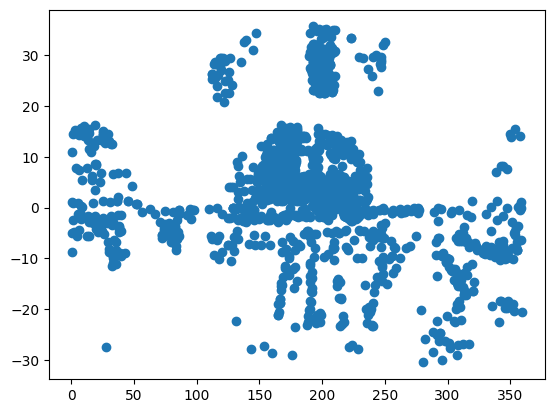

In [12]:
fig, ax=plt.subplots()
ax.scatter(ras0, decs0)

In [13]:
def compute_mags_from_reference(spt, mag_key, ref):
    vals, unc= polynomial_relation(spt, 'spt', mag_key, ref, nsample=1, xerr=0.0)
    return np.random.normal(vals, unc)

def get_best2018_relation(spt, flt):
    return spe.typeToMag(spt, flt, ref='best2018')

def get_ps1_mags(df):
    gs= get_best2018_relation(df.spt, 'PANSTARRS_G')
    rs=compute_mags_from_reference(df.spt, 'r_ps1', 'freeser2022')
    imags=compute_mags_from_reference(df.spt, 'i_ps1', 'freeser2022')
    zs=compute_mags_from_reference(df.spt, 'z_ps1', 'freeser2022')
    ys=compute_mags_from_reference(df.spt, 'y_ps1', 'freeser2022')
    
    #use beset et al for <16
    best_gs= get_best2018_relation(df.spt, 'PANSTARRS_G')
    best_rs= get_best2018_relation(df.spt, 'PANSTARRS_R')
    best_is= get_best2018_relation(df.spt, 'PANSTARRS_I')
    best_zs= get_best2018_relation(df.spt, 'PANSTARRS_Z')
    best_ys= get_best2018_relation(df.spt, 'PANSTARRS_Y')

    #mask
    mask= df['spt']<=20

    for m, ml in zip([gs, rs, imags, zs, ys], ['G', 'R', 'I', 'Z', 'Y']):
        df['abs_PANSTARRS_{}'.format(ml)]=np.random.normal(m[0], m[1])
        df['PANSTARRS_{}'.format(ml)]=   df['abs_PANSTARRS_{}'.format(ml)]+5*np.log10(df.distance/10.0)
       
    for m, ml in zip([best_gs, best_rs, best_is, best_zs, best_ys], ['G', 'R', 'I', 'Z', 'Y']):
        df['abs_PANSTARRS_{}'.format(ml)]=np.random.normal(m[0], m[1])
        df['PANSTARRS_{}'.format(ml)]=   df['abs_PANSTARRS_{}'.format(ml)]+5*np.log10(df.distance/10.0)
        
    return df

In [17]:
def simulate_survey(keys, maglimit, ps1=False):
    #use the brighest magnitude cut
    #k= [k for k in maglimit.keys()][0]
    #absmag= np.poly1d(popsims.simulator.POLYNOMIALS['absmags_spt']['dwarfs'][k]['fit'])(15)
    #mag_cut= maglimit[k]
    #dmax=10.**(-(absmag-mag_cut)/5. + 1.)
    #--> to be more precise, can simulate within volume for given spt
    #samples=pd.DataFrame()
    
    #special case for thin disk panstarrs, use the mag relations from freeser
    
    #thin disk
    
    dfs=[]
    
    for dmax in [100, 1000, 5_000]:

        p1=Population(evolmodel= 'burrows1997',
                      imf_power=-0.6,
                      binary_fraction=0.2,
                      age_range=[0, 8],
                      mass_range=[0.01, .1],
                     nsample=1e4)

        p1.simulate()

        p1.add_distances( Disk(H=300, L=2600), footprint.galactic.l.radian[sights],footprint.galactic.b.radian[sights], 0.1,  dmax, dsteps=1000)

        #add magnitudes from pre-defined filters or pre-define polynomial cofficients
        p1.add_magnitudes(keys, get_from='spt',object_type='dwarfs')
        p1.add_kinematics(footprint.ra.degree, footprint.dec.degree, kind='thin_disk', red_prop_motions_keys=keys)

        p2=Population(evolmodel= 'burrows1997',
                      imf_power=-0.6,
                      binary_fraction=0.2,
                      age_range=[8, 14],
                      mass_range=[0.01, .1],
                     nsample=1e4)

        p2.simulate()

        p2.add_distances( Disk(H=900, L=3600), footprint.galactic.l.radian[sights],footprint.galactic.b.radian[sights], 0.1,  dmax)

        #add magnitudes from pre-defined filters or pre-define polynomial cofficients
        p2.add_magnitudes(keys, get_from='spt',object_type='dwarfs')
        p2.add_kinematics(footprint.ra.degree, footprint.dec.degree, kind='thick_disk', red_prop_motions_keys=keys)



        p3=Population(evolmodel= 'burrows1997',
                      imf_power=-0.6,
                      binary_fraction=0.2,
                      age_range=[10, 14],
                      mass_range=[0.01, .1],
                     nsample=1e4)

        p3.simulate()

        p3.add_distances( Halo(), footprint.galactic.l.radian[sights],footprint.galactic.b.radian[sights], 0.1, dmax)
       

        #add magnitudes from pre-defined filters or pre-define polynomial cofficients
        p3.add_magnitudes(keys, get_from='spt',object_type='dwarfs')
        p3.add_kinematics(footprint.ra.degree, footprint.dec.degree, kind='halo', red_prop_motions_keys=keys)

        p1.scale_to_local_lf()
        p2.scale_to_local_lf()
        p3.scale_to_local_lf()

        mag_cols= np.concatenate([['abs_'+x for x in keys], keys, ['redH_'+x for x in keys]])
        cols=np.concatenate([mag_cols, ['scale', 'mass', 'age', 'temperature', \
                                        'scale_unc', 'scale_times_model', 'l', 'b','distance']])

        df1=p1.to_dataframe(cols)
        df1['population']='thin disk'

        df2=p2.to_dataframe(cols)
        df2['population']='thick disk'

        df3=p3.to_dataframe(cols)
        df3['population']='halo'

        df=pd.concat([df1, df2, df3]).reset_index(drop=True)
    
        #apply magnitude cuts

        df=df[np.logical_and.reduce([df[k] <  maglimit[k] for k in maglimit.keys() ])].reset_index(drop=True)
        
        dfs.append(df)

    return pd.concat(dfs)
    
    

In [15]:
#footprint.galactic.l.radian

In [18]:
#run a combined ukidss-sdss 
ukidss_sdss0= simulate_survey(['SDSS_G', 'SDSS_R','SDSS_I', 'SDSS_Z', 
                             'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K'], \
                             {'UKIDSS_Y': 20.3, 'UKIDSS_J': 19.9})
#Y=20.3,J=19.9,H=18.6,K=18.2
#G=23.15

In [19]:
ukidss_sdss0.columns

Index(['abs_SDSS_G', 'abs_SDSS_R', 'abs_SDSS_I', 'abs_SDSS_Z', 'abs_UKIDSS_Y',
       'abs_UKIDSS_J', 'abs_UKIDSS_H', 'abs_UKIDSS_K', 'SDSS_G', 'SDSS_R',
       'SDSS_I', 'SDSS_Z', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K',
       'redH_SDSS_G', 'redH_SDSS_R', 'redH_SDSS_I', 'redH_SDSS_Z',
       'redH_UKIDSS_Y', 'redH_UKIDSS_J', 'redH_UKIDSS_H', 'redH_UKIDSS_K',
       'scale', 'mass', 'age', 'temperature', 'scale_unc', 'scale_times_model',
       'l', 'b', 'distance', 'population'],
      dtype='object')

In [20]:
def apply_other_cuts_ukidss(t):
    #additional cuts 
    #HJ > -0.9375*(I-J)+ 19.59375
    #J-K <= 0.125*(I-J)+ 0.4875
    #additional cuts
    # HJ >=  −2.14848* (z-J)+ 20.36963
    # J-K <= 0.2963 *(z-J)+ 0.374
    mask0= t.redH_UKIDSS_J > -0.9375*(t.SDSS_I-t.UKIDSS_J)+19.59375
    mask1= (t.UKIDSS_J-t.UKIDSS_K) <= 0.125*(t.SDSS_I-t.UKIDSS_J)+0.4875
    mask2= t.redH_UKIDSS_J > -2.14848*(t.SDSS_Z-t.UKIDSS_J)+20.36963
    mask3= (t.UKIDSS_J-t.UKIDSS_K)<=  0.2963*(t.SDSS_Z-t.UKIDSS_J)+0.374
    
    t=t[np.logical_and.reduce([mask0, mask1, mask2, mask3])]

    return t

ukidss_sdss_r= apply_other_cuts_ukidss(ukidss_sdss0)

In [21]:
ukidss_sdss=ukidss_sdss_r.query('UKIDSS_Y < 20.3 and UKIDSS_J <19.9 and UKIDSS_H < 18.6 and UKIDSS_K < 18.2 and SDSS_G < 22.2 and SDSS_R < 22.2 and SDSS_I < 21.3 and SDSS_Z< 20.5 ' )

In [22]:
ukidss_sdss_thin=ukidss_sdss_r.query('population == "thin disk"')
ukidss_sdss_thick=ukidss_sdss_r.query('population == "thick disk"')
ukidss_sdss_halo=ukidss_sdss_r.query('population =="halo"')

In [23]:
colors=['#AAAAAA', '#FF851B', '#0074D9']
pops=[ukidss_sdss_thin, ukidss_sdss_thick, ukidss_sdss_halo]
names=['thin disk', 'thick disk', 'halo']
sizes=[.1, .1, .1]
markers=['.', '^', '*']

In [24]:
#additional cuts

In [25]:
#run a combined ukidss-sdss 
vhs_sdss= simulate_survey(['SDSS_G', 'SDSS_R','SDSS_I', 'SDSS_Z', 
                             'VISTA_Y', 'VISTA_J', 'VISTA_H', 'VISTA_KS'], \
                             {'SDSS_G': 23.15})
#Y=20.3,J=19.9,H=18.6,K=18.2

In [26]:
#u=22.0, g=22.2, r=22.2, i=21.3, z=20.5
vhs_sdss=vhs_sdss.query('VISTA_J < 19.5 and VISTA_H < 18.6 and VISTA_KS < 17.9 and \
SDSS_G < 22.2 and SDSS_R < 22.2 and SDSS_I < 21.3 and SDSS_Z< 20.5')

In [27]:
vhs_ps1=  simulate_survey(['PANSTARRS_G', 'PANSTARRS_R','PANSTARRS_I', 'PANSTARRS_Z', 'PANSTARRS_Y',
                             'VISTA_Y', 'VISTA_J', 'VISTA_H', 'VISTA_KS'], \
                             {'VISTA_J': 19.5}, ps1=True)

KeyError: 'PANSTARRS_G'

In [ ]:
vhs_ps1.head(5)

In [ ]:
vhs_ps1=vhs_ps1.query('PANSTARRS_G < 23.3 and PANSTARRS_R < 23.2 and PANSTARRS_I < 23.1 \
and PANSTARRS_Z < 22.3 and PANSTARRS_Y < 21 and VISTA_J < 19.5 and VISTA_H < 18.6 and VISTA_KS < 17.9')

In [ ]:
sptgrid=np.arange(10, 40)
res_ukidss_sdss=compute_vols_and_numbers(ukidss_sdss, sptgrid, footprint, {'UKIDSS_J': [14, 20]})

In [ ]:
#comon area according to the paper 3667, 1681 and 7692 square degrees fo
# UKIDSS-SDSS, VHS-SDSS and VHS-PS, respectively 
AREA_UKIDSS_SDSS=3667*(u.degree**2).to(u.radian**2)*(u.radian**2)
AREA_VHS_SDSS=1681*(u.degree**2).to(u.radian**2)*(u.radian**2)
AREA_VHS_PS1=7692*(u.degree**2).to(u.radian**2)*(u.radian**2)

In [ ]:
res_vhs_sdss=compute_vols_and_numbers(vhs_sdss, sptgrid, footprint, {'VISTA_Y': [14, 20]})

In [ ]:
res_ukidss_sdss[0].index

In [ ]:
res_vhs_ps1=compute_vols_and_numbers(vhs_ps1, sptgrid, footprint, {'VISTA_Y': [14, 20]})

In [ ]:
#res_vhs_ps1

In [ ]:
fig, ax=plt.subplots(figsize=(14, 4), ncols=3)

ax[0].step(res_ukidss_sdss[0].index, res_ukidss_sdss[0].thin*res_ukidss_sdss[1].thin*AREA_UKIDSS_SDSS/AREA_UKIDSS_SDSS.to(u.degree**2),\
        color=colors[0],  linestyle='dotted', label='Thin Disk')
ax[0].step(res_ukidss_sdss[0].index, 0.12*res_ukidss_sdss[0].thick*res_ukidss_sdss[1].thick*AREA_UKIDSS_SDSS/AREA_UKIDSS_SDSS.to(u.degree**2), \
        color=colors[1], linestyle='--', label='Thick Disk')
ax[0].step(res_ukidss_sdss[0].index, 0.0025*res_ukidss_sdss[0].halo*res_ukidss_sdss[1].thick*AREA_UKIDSS_SDSS/AREA_UKIDSS_SDSS.to(u.degree**2), \
        color=colors[-1], linestyle='-',  label='Halo')

ax[1].step(res_vhs_sdss[0].index, res_vhs_sdss[0].thin*res_vhs_sdss[1].thin*AREA_VHS_SDSS/AREA_VHS_SDSS.to(u.degree**2),\
        color=colors[0],  linestyle='dotted', label='Thin Disk')
ax[1].step(res_vhs_sdss[0].index, 0.12*res_vhs_sdss[0].thick*res_vhs_sdss[1].thick*AREA_VHS_SDSS/AREA_VHS_SDSS.to(u.degree**2), \
        color=colors[1], linestyle='--', label='Thick Disk')
ax[1].step(res_vhs_sdss[0].index, 0.0025*res_vhs_sdss[0].halo*res_vhs_sdss[1].thick*AREA_VHS_SDSS/AREA_VHS_SDSS.to(u.degree**2), \
        color=colors[-1], linestyle='-',  label='Halo')


ax[-1].step(res_vhs_ps1[0].index, res_vhs_ps1[0].thin*res_vhs_ps1[1].thin*AREA_VHS_PS1/AREA_VHS_PS1.to(u.degree**2),\
        color=colors[0],  linestyle='dotted', label='Thin Disk')
ax[-1].step(res_vhs_ps1[0].index, 0.12*res_vhs_ps1[0].thick*res_vhs_ps1[1].thick*AREA_VHS_PS1/AREA_VHS_PS1.to(u.degree**2), \
        color=colors[1], linestyle='--', label='Thick Disk')
ax[-1].step(res_vhs_ps1[0].index, 0.0025*res_vhs_ps1[0].halo*res_vhs_ps1[1].thick*AREA_VHS_PS1/AREA_VHS_PS1.to(u.degree**2), \
        color=colors[-1], linestyle='-',  label='Halo')




ax[0].set(yscale='log', ylabel=r'Surface Density (deg $^{-2})$',\
       xlabel='Spectral Type', title='UKIDSS-SDSS')

ax[1].set(yscale='log', ylabel=r'Surface Density (deg $^{-2})$',\
       xlabel='Spectral Type', title='VHS-SDSS')

ax[-1].set(yscale='log', ylabel=r'Surface Density (deg $^{-2})$',\
       xlabel='Spectral Type', title='VHS-PS1')



for a in ax:
    a.legend(fontsize=10, loc='upper right')
    a.set(yscale='log')
    
ax[0].set(xticks=[10, 15,20, 25], xticklabels=['M0', 'M5', 'L0', 'L5'])
ax[1].set(xticks=[10, 15,20, 25], xticklabels=['M0', 'M5', 'L0', 'L5'])
ax[-1].set(xticks=[10, 15,20, 25], xticklabels=['M0', 'M5', 'L0', 'L5'])



plt.tight_layout()
plt.savefig('../figures/plot_simulatedncounts.pdf')

In [ ]:
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(12, 10))

ax[0][0].scatter(dfl_conct.SDSSi-dfl_conct.Hmag_LAS, dfl_conct.Jmag_LAS-dfl_conct.Kmag_LAS, s=10, c='k' )
ax[0][1].scatter(dfl_conct.SDSSi-dfl_conct.Jmag_LAS, dfl_conct.Hj, s=10, c='k'  )

ax[1][0].scatter(dfl_conct.SDSSz-dfl_conct.Jmag_LAS, dfl_conct.Jmag_LAS-dfl_conct.Kmag_LAS, s=10, c='k' )
ax[1][1].scatter(dfl_conct.SDSSz-dfl_conct.Jmag_LAS, dfl_conct.Hj, s=10, c='k' )


for idx in range(0, 3):
    p= pops[idx]
    c=colors[idx]
    n=names[idx]
    s=sizes[idx]
    m= markers[idx]
    
    ax[0][0].scatter(p.SDSS_I-p.UKIDSS_J, p.UKIDSS_J-p.UKIDSS_K, s=s, marker=m, color=c, label=n, alpha=0.1)
    sns.kdeplot(p.SDSS_I-p.UKIDSS_J, p.UKIDSS_J-p.UKIDSS_K, color=c, ax=ax[0][0])
    
    ax[0][1].scatter(p.SDSS_I-p.UKIDSS_J, p.redH_UKIDSS_H, s=s, marker=m, color=c, label=n, alpha=0.1)
    sns.kdeplot(p.SDSS_I-p.UKIDSS_J, p.redH_UKIDSS_H,color=c, ax=ax[0][1])

    ax[1][0].scatter(p.SDSS_Z-p.UKIDSS_J, p.UKIDSS_J-p.UKIDSS_K,  marker=m,  s=s, color=c, label=n, alpha=0.1)
    sns.kdeplot(p.SDSS_Z-p.UKIDSS_J, p.UKIDSS_J-p.UKIDSS_K, ax=ax[1][0], color=c)
    
    ax[1][1].scatter(p.SDSS_Z-p.UKIDSS_J, p.redH_UKIDSS_H, s=s,  marker=m,color=c, label=n, alpha=0.1)
    sns.kdeplot(p.SDSS_Z-p.UKIDSS_J, p.redH_UKIDSS_H, color=c, ax=ax[1][1])




for a in np.concatenate(ax):
    l=a.legend(fontsize=14, markerscale=50)
ax[0][0].set(xlabel='SDSSi-J', ylabel='J-K', xlim=[0, 6], ylim=[-0.5, 1.5])
ax[0][1].set(xlabel='SDSSi-J', ylabel=r'H$_J$',  xlim=[0, 6], ylim=[10, 24])
ax[0][1].invert_yaxis()

ax[1][0].set(xlabel='SDSSz-J', ylabel='J-K', xlim=[0, 5.5], ylim=[-0.5, 1.5])
ax[1][1].set(xlabel='SDSSz-J', ylabel=r'H$_J$', xlim=[0, 5.5], ylim=[10, 24])
ax[1][1].invert_yaxis()


plt.tight_layout()

plt.savefig('../figures/plot_simulatedcolors_sdss_ukidss.jpeg')
